<a href="https://colab.research.google.com/github/BaranovTim/AI-Model-for-Clothing-Recognition/blob/main/computer_vision_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
train_data = datasets.FashionMNIST (
    root = 'data_2',
    train = True,
    target_transform= None,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
test_data = datasets.FashionMNIST (
    root = 'data_2',
    train = False,
    target_transform= None,
    transform = torchvision.transforms.ToTensor(),
    download = True
)

class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
BATCH_SIZE = 32

train_batch = DataLoader( shuffle=True,
                          dataset=train_data,
                          batch_size = BATCH_SIZE,
                          )

test_batch = DataLoader( shuffle=False,
                          dataset=test_data,
                          batch_size = BATCH_SIZE,
                          )

first_batch_imgs, first_batch_class = next(iter(train_batch))
first_batch_class

class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# Custom MinPool2d
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MinPool2d, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride, padding)

    def forward(self, x):
        return -self.pool(-x)


In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_layers, output_layers, hidden_units):
    super().__init__()
    self.stack_1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_layers,
            out_channels = hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2)
        )
    self.stack_2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2)
        )
    self.classifier = nn.Sequential(
       nn.Flatten(),
       nn.Linear(in_features=hidden_units*7*7,
                 out_features = output_layers)
      )

  def forward(self, x):
    x = self.stack_1(x)
    x = self.stack_2(x)
    x = self.classifier(x)
    return x



In [ ]:
torch.manual_seed(8)
model = FashionMNISTModel(input_layers=1,
                          hidden_units=10,
                          output_layers=len(class_names)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr= 0.1)

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_acc, train_loss = 0, 0
  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'train_loss: {train_loss:.5f} | train_accuracy: {train_acc:.2f}')

def test(model, data_loader, loss_fn, accuracy_fn, device):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f'test_loss: {test_loss:.5f}| test_acc:{test_acc:.2f}')


In [ ]:
def eval(model, data_loader, loss_fn, accuracy_fn, device=device):
  loss, acc =0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
       X.to(device), y.to(device)
       y_pred = model(X)
       loss += loss_fn(y_pred, y)
       acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
          'model_loss': loss.item(),
          'model_acc': acc}


In [ ]:
epochs = 3
for epoch in range(epochs):
  train(model=model, data_loader=train_batch, loss_fn= loss_fn, accuracy_fn=accuracy_fn, optimizer=optimizer, device=device)
  test(model=model, data_loader=test_batch, loss_fn= loss_fn, accuracy_fn=accuracy_fn, device=device)


train_loss: 0.66987 | train_accuracy: 75.36
test_loss: 0.41413| test_acc:85.20
train_loss: 0.37740 | train_accuracy: 86.24
test_loss: 0.37582| test_acc:86.31
train_loss: 0.33194 | train_accuracy: 87.94
test_loss: 0.33363| test_acc:87.62


In [ ]:
#Calculate model_0 results on test dataset
model_results = eval(model=model,
                      data_loader=test_batch,
                      loss_fn=loss_fn,
                      accuracy_fn=accuracy_fn,
                      device=device)
model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3336285352706909,
 'model_acc': 87.61980830670926}

In [ ]:
import random

random.seed(50)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for sample in data:
      #Prepare the sample(add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      #Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      #Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      #get pred_prob off the GPU for further calc
      pred_probs.append(pred_prob.cpu())

  #Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

#make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

#Convert pred probabilities to labels
pred_classes = pred_probs.argmax(dim=1)


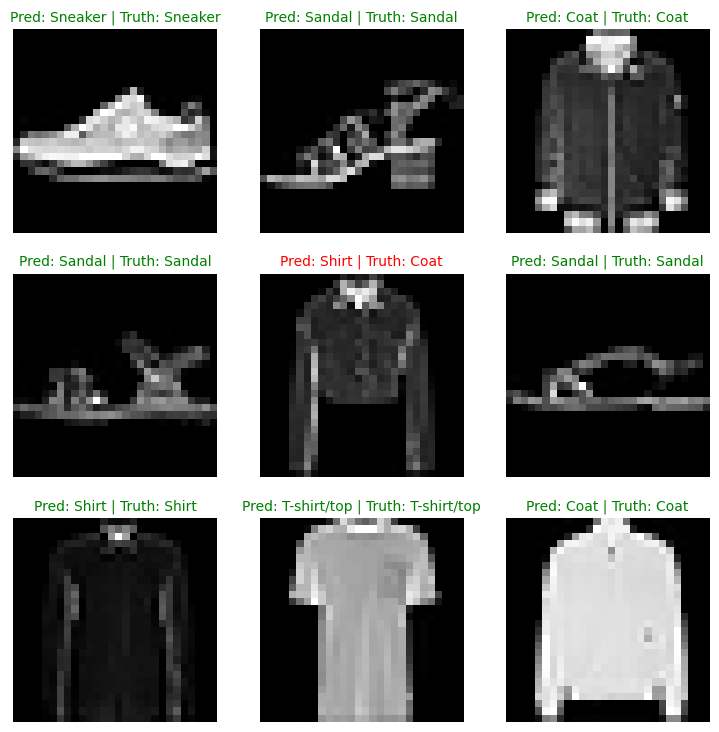

In [ ]:
#Plot preds
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  #Create subplot
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')

  # Find the prediction (in text form, e.q 'sandal')
  pred_label = class_names[pred_classes[i]]

  #Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  #Create title
  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')

  plt.axis(False)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
def precision_recall_f1(model, data_loader, device=device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Weighted = accounts for class imbalance, Macro = equal weight for each class
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names))

    return precision, recall, f1


In [ ]:
precision, recall, f1 = precision_recall_f1(model, test_batch, device=device)


Precision: 0.8766607369404253
Recall: 0.8761
F1-score: 0.8760586010258048

Classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.86      0.79      0.82      1000
     Trouser       0.97      0.97      0.97      1000
    Pullover       0.81      0.81      0.81      1000
       Dress       0.87      0.87      0.87      1000
        Coat       0.75      0.81      0.78      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.66      0.65      0.65      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def get_all_preds(model, data_loader, device=device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.softmax(logits, dim=1)   # class probabilities
            preds = probs.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_probs)


In [ ]:
y_true, y_pred, y_probs = get_all_preds(model, test_batch, device)


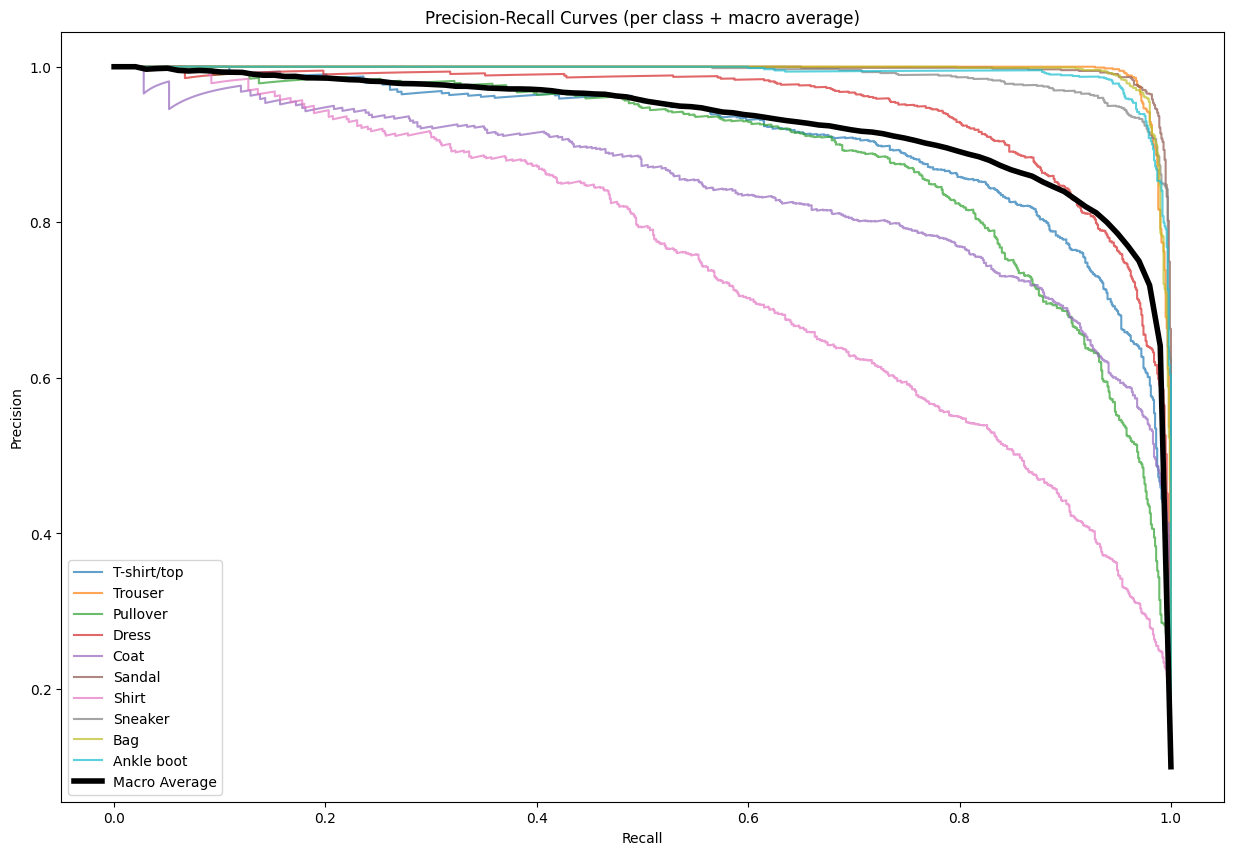

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_pr_curves(y_true, y_probs, class_names):
    plt.figure(figsize=(15, 10))

    # --- One-vs-Rest curves per class ---
    precisions_list, recalls_list = [], []
    for i, name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(
            (y_true == i).astype(int), y_probs[:, i]
        )
        plt.plot(recall, precision, label=name, alpha=0.7)
        precisions_list.append(np.interp(np.linspace(0,1,100), recall[::-1], precision[::-1]))
        recalls_list.append(np.linspace(0,1,100))

    # --- Macro-average curve ---
    precisions_macro = np.mean(precisions_list, axis=0)
    recalls_macro = np.linspace(0,1,100)

    plt.plot(
        recalls_macro,
        precisions_macro,
        label="Macro Average",
        linewidth=4,
        color="black"
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (per class + macro average)")
    plt.legend()
    plt.show()


plot_pr_curves(y_true, y_probs, class_names)



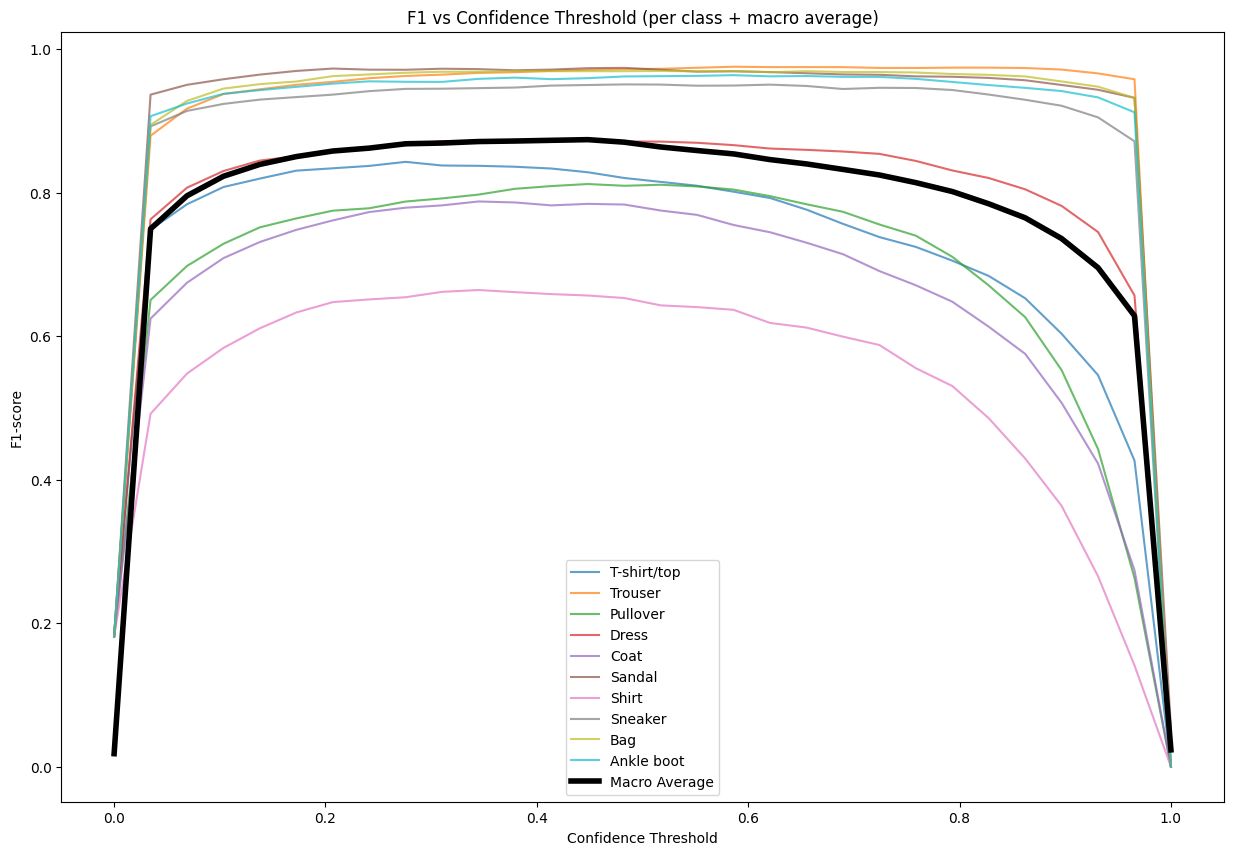

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

def plot_f1_vs_confidence(y_true, y_probs, class_names):
    thresholds = np.linspace(0, 1, 30)
    plt.figure(figsize=(15, 10))

    # --- Per-class curves ---
    for i, name in enumerate(class_names):
        f1_scores = []
        for t in thresholds:
            preds_t = (y_probs[:, i] >= t).astype(int)
            f1_scores.append(
                f1_score((y_true == i).astype(int), preds_t, zero_division=0)
            )
        plt.plot(thresholds, f1_scores, label=name, alpha=0.7)

    # --- Macro-average curve ---
    f1_macro = []
    for t in thresholds:
        preds_t = (y_probs >= t).astype(int)
        # многоклассовая F1 (macro average)
        f1_macro.append(
            f1_score(y_true, preds_t.argmax(axis=1), average="macro", zero_division=0)
        )

    plt.plot(
        thresholds,
        f1_macro,
        label="Macro Average",
        linewidth=4,  # толще линия
        color="black" # цвет можно задать явно
    )

    plt.xlabel("Confidence Threshold")
    plt.ylabel("F1-score")
    plt.title("F1 vs Confidence Threshold (per class + macro average)")
    plt.legend()
    plt.show()

plot_f1_vs_confidence(y_true, y_probs, class_names)

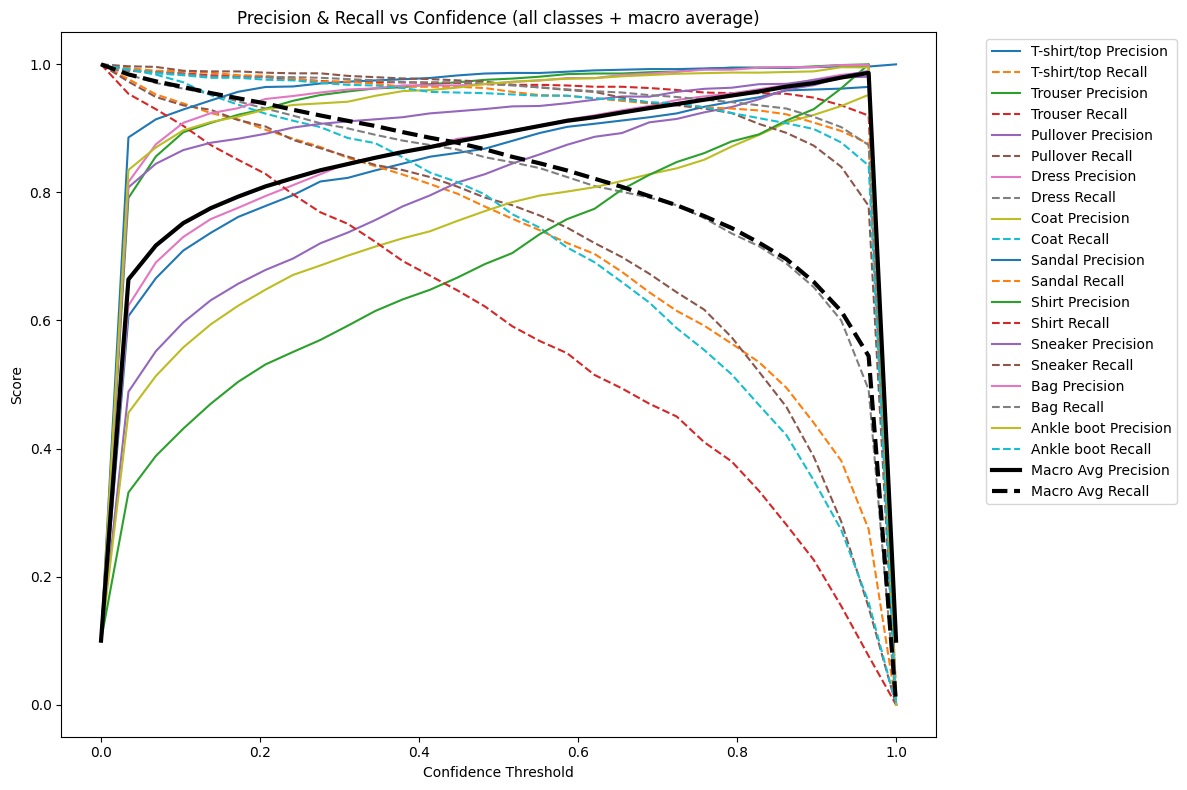

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def plot_pr_vs_confidence_all(y_true, y_probs, class_names, n_thresholds=30):
    thresholds = np.linspace(0, 1, n_thresholds)

    plt.figure(figsize=(12, 8))

    n_classes = y_probs.shape[1]

    # Для macro average будем собирать per-class значения и усреднять
    macro_precisions = []
    macro_recalls = []

    for t in thresholds:
        per_class_prec = []
        per_class_rec = []
        for i in range(n_classes):
            y_true_i = (y_true == i).astype(int)
            preds_i = (y_probs[:, i] >= t).astype(int)
            per_class_prec.append(precision_score(y_true_i, preds_i, zero_division=0))
            per_class_rec.append(recall_score(y_true_i, preds_i, zero_division=0))
        # среднее по классам = macro
        macro_precisions.append(np.mean(per_class_prec))
        macro_recalls.append(np.mean(per_class_rec))

    # Построим по классам
    for i, name in enumerate(class_names):
        precisions, recalls = [], []
        for t in thresholds:
            preds_t = (y_probs[:, i] >= t).astype(int)
            precisions.append(precision_score((y_true == i).astype(int), preds_t, zero_division=0))
            recalls.append(recall_score((y_true == i).astype(int), preds_t, zero_division=0))

        plt.plot(thresholds, precisions, label=f"{name} Precision")
        plt.plot(thresholds, recalls, linestyle="--", label=f"{name} Recall")

    # Macro average (толще линии)
    plt.plot(thresholds, macro_precisions, color="black", linewidth=3, label="Macro Avg Precision")
    plt.plot(thresholds, macro_recalls, color="black", linewidth=3, linestyle="--", label="Macro Avg Recall")

    plt.xlabel("Confidence Threshold")
    plt.ylabel("Score")
    plt.title("Precision & Recall vs Confidence (all classes + macro average)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()



plot_pr_vs_confidence_all(y_true, y_probs, class_names)



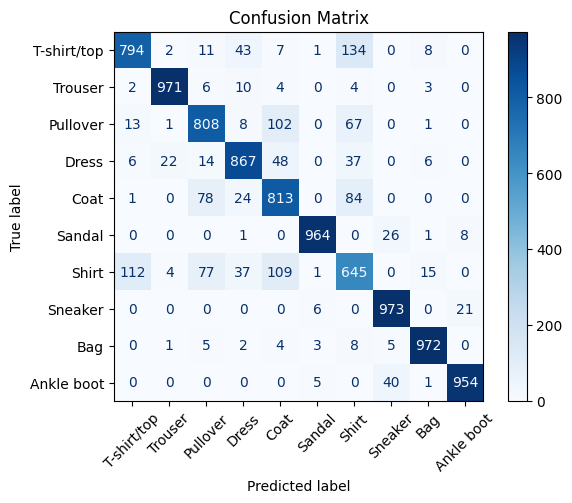

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix")
plt.show()
